## Parameter (.top) file parser functions

In [1]:
import re
import glob
from typing import Tuple
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def read_rawdata(file_nr):
    folder = "../Parameter files (.top)/"
    filename = "NVE_par_"+str(file_nr)+".top"
    filepath = folder + filename

    with open(filepath, 'rb') as f:
        rawdata = f.readlines()
    
    return rawdata    

In [5]:
def get_param_value(data, key: str):
    value = 0
    for line in data:
        if (" "+key+" ") in str(line):
            value = re.findall("\d+\.\d+", str(line))
    
    return float(value[0])

## Key data to read from .top file

In [8]:
## Interesting key data to read

# Elevation data
ELEVS = ["ELEV"+str(i) for i in range(11)]

# Evaporation per month
EVAPOS = ["EPJAN", "EPFEB", "EPMAR", "EPAPR", "EPMAY", "EPJUN", "EPJUL", "EPAUG", "EPSEP", "EPOKT", "EPNOV", "EPDES"]

# Other params 
OTHER = ["RCORR", "SCORR", "PGRAD", "TPGRAD"]

interesting_keys = [ELEVS, OTHER, EVAPOS]
# Flatten lists inside list
interesting_keys = [val for sublist in interesting_keys for val in sublist]

In [9]:
def read_interesting_params(file_nr, keys):
    data = read_rawdata(file_nr)
    params_dict = {}
    for key in keys: 
        params_dict[key] = get_param_value(data, key)
    return params_dict

In [10]:
file_nr = 1
read_interesting_params(file_nr, interesting_keys)

{'ELEV0': 670.0,
 'ELEV1': 894.0,
 'ELEV2': 1023.0,
 'ELEV3': 1109.0,
 'ELEV4': 1196.0,
 'ELEV5': 1261.0,
 'ELEV6': 1304.0,
 'ELEV7': 1335.0,
 'ELEV8': 1361.0,
 'ELEV9': 1391.0,
 'ELEV10': 1534.0,
 'RCORR': 1.594,
 'SCORR': 1.768,
 'PGRAD': 0.05,
 'TPGRAD': 0.5,
 'EPJAN': 0.1,
 'EPFEB': 0.2,
 'EPMAR': 0.7,
 'EPAPR': 1.0,
 'EPMAY': 2.3,
 'EPJUN': 3.5,
 'EPJUL': 3.5,
 'EPAUG': 2.3,
 'EPSEP': 1.0,
 'EPOKT': 0.7,
 'EPNOV': 0.2,
 'EPDES': 0.1}

## NVE specific data loader function

In [11]:
# Read input txt files
def dateparse(dates, times):
    return [
        pd.datetime.strptime(date + time, "%d.%m.%Y%H:%M:%S")
        for date, time in zip(dates, times)
    ]

def load_forcing_and_discharge(catchment: int) -> Tuple[pd.DataFrame, int]:
    """Load the meteorological forcing data of a specific catchment.

    :param catchment: number (id)
    
    :return: pd.DataFrame containing the meteorological forcing data.
    """
    path = '../Input files (.txt)'
    all_files = glob.glob(path + "/*.txt")

    file_exist = False
    
    # Loop through files and find correct catchment
    for file_path in all_files:
        # Name is formatted `./Input files (.txt)/nve_inp_XX.txt`
        number = int(file_path.split('_')[-1].split('.')[0])
        
        if number == catchment:
            file_exist = True
            df = pd.read_csv(
                file_path, 
                encoding='cp1252', 
                skiprows=[0], 
                delimiter=r"\s+", 
                parse_dates=[['dd.mm.yyyy',  'hh:mm:ss']],
                date_parser=dateparse)
            df = df.rename(columns={"dd.mm.yyyy_hh:mm:ss": "timestamp"})
    
    # Return None if catchment does not exist
    if file_exist == False:
        print("Catchment does not exist")
        return None
    else:
        return df

In [12]:
print("Input file data:") 
load_forcing_and_discharge(file_nr).head()

Input file data:


<ipython-input-11-ecc3a6e4ca2c>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime.strptime(date + time, "%d.%m.%Y%H:%M:%S")


,timestamp,mm,grC,grC.1,m3/s
0,2000-01-01,3.30,-3.75,-3.75,0.27
1,2000-01-02,3.79,-2.02,-2.02,0.27
2,2000-01-03,6.98,-3.84,-3.84,0.27
3,2000-01-04,16.53,-3.80,-3.80,0.29
4,2000-01-05,4.44,-4.78,-4.78,0.31


## Read Output, Simulated and Residuals data

In [31]:
def read_output_simulated_residual_data(file_nr):
    # Read raw csv
    folder = "../Residual, Output, Simulated data, EPOT/"
    filename = "PINE_output_"+str(file_nr)+".csv"
    filepath = folder + filename
    
    df = pd.read_csv(filepath)
    
    # Rename columns to match LSTM notebook
    df = df.rename(columns={"Date": "timestamp"})
    
    # Cast timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y/%m/%d', yearfirst=True)
    
    # Remove first column
    df = df.drop(['Unnamed: 0'], axis=1)
    
    return df

In [32]:
print("Residual file data:")
read_output_simulated_residual_data(file_nr).head()

Residual file data:


,timestamp,Q_obs,Q_sim,Residual,EPOT
0,2000-01-01,0.27,0.006,-0.264,0.1
1,2000-01-02,0.27,0.025,-0.245,0.1
2,2000-01-03,0.27,0.047,-0.223,0.1
3,2000-01-04,0.29,0.080,-0.210,0.1
4,2000-01-05,0.31,0.100,-0.210,0.1


## Merge parameter data with rainfall-runoff data

<ipython-input-11-ecc3a6e4ca2c>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime.strptime(date + time, "%d.%m.%Y%H:%M:%S")


Text(0.5, 1.0, 'Evapo plot for a year (simple model)')

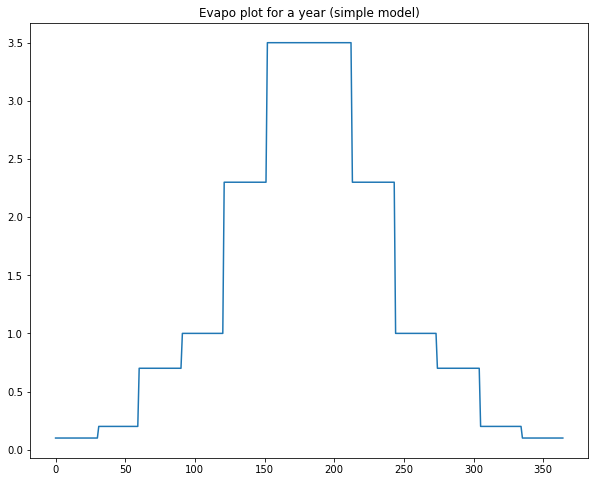

In [33]:
def generate_evapo_data(df, params):
    # Copies evapotranspiration given for a month to every days in the same month
    evapos = []
    for d in range(len(df)):
        # Calculate index based on month number
        month_idx = df["timestamp"][d].month - 1
        evapos.append(params[EVAPOS[month_idx]])
        
    # Returns list                        
    return evapos  

# Load rain, discharge and params file
df = load_forcing_and_discharge(file_nr)
params = read_interesting_params(file_nr, interesting_keys)

# Evapo plot for a year (simple model)
plt.figure(figsize=(10,8))
plt.plot(generate_evapo_data(df, params)[0:365])
plt.title("Evapo plot for a year (simple model)")

<ipython-input-11-ecc3a6e4ca2c>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime.strptime(date + time, "%d.%m.%Y%H:%M:%S")


Text(0.5, 1.0, 'Temperature plot for 30 days (simple model) for all 10 areas, dotted is with no correction')

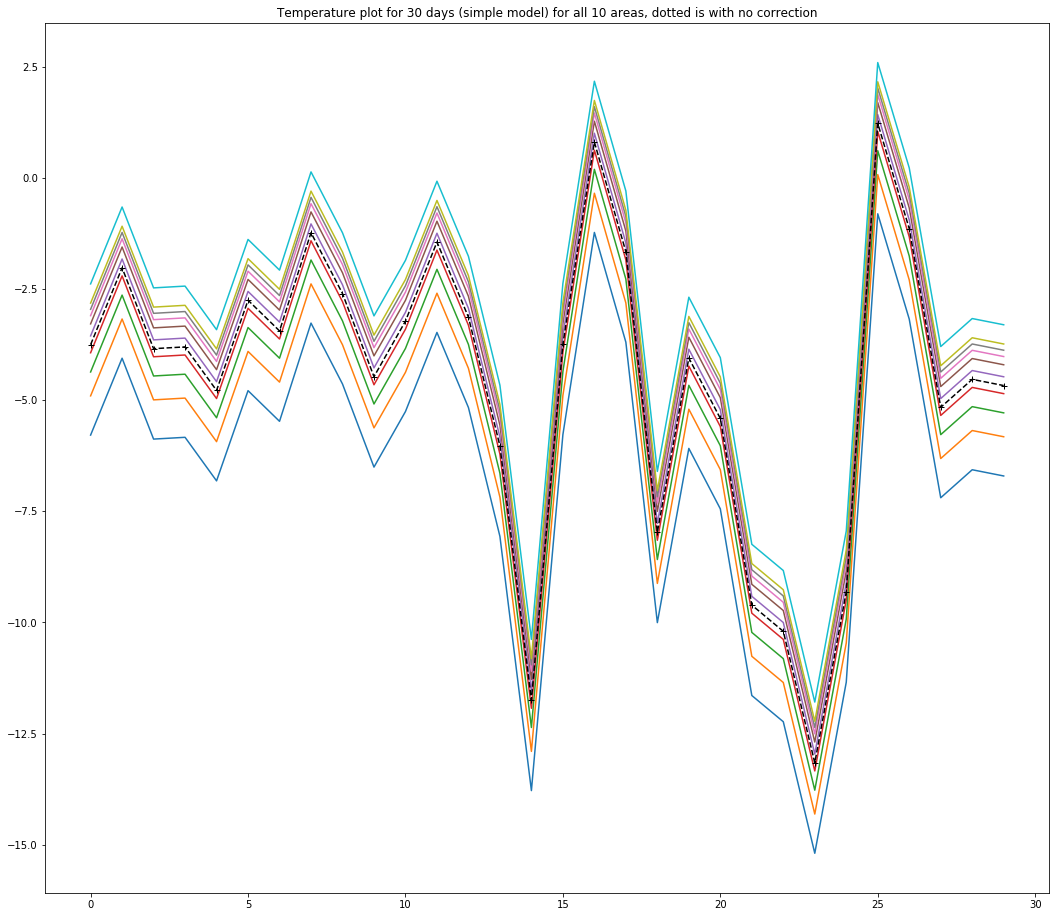

In [34]:
def generate_temp_data(df, params):
    temps = []
    for d in range(len(df)):
        # Loop through 10 distributed areas 
        elevation = []
        sum_height = params[ELEVS[0]]
        
        for i in range(10):
            # Calculate height of a given area by averaging lowest and highest height 
            height_low = params[ELEVS[i]]
            height_hig = params[ELEVS[i+1]]
            elevation.append((height_hig + height_low) / 2.0)
            
            sum_height += params[ELEVS[i+1]]
        
        # Find average height of catchment
        avg_height = sum_height / 11.0
        
        # Calculate elevation corrected temperature
        temp = []
        for i in range(10):
            temp.append(df["grC"][d] + params["TPGRAD"] * (elevation[i] - avg_height) / 100.0)
        temps.append(temp)    
    return temps

# Tempeature plot for a year (simple model) for all 10 areas
df = load_forcing_and_discharge(file_nr)
temps = generate_temp_data(df, params)

plt.figure(figsize=(18,16))
plt.plot(temps[0:30])
plt.plot(df["grC"][0:30], 'k--+')
plt.title("Temperature plot for 30 days (simple model) for all 10 areas, dotted is with no correction")

<ipython-input-11-ecc3a6e4ca2c>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime.strptime(date + time, "%d.%m.%Y%H:%M:%S")


Text(0.5, 1.0, 'Rain plot for 30 days (simple model) for all 10 areas, dotted is with no correction')

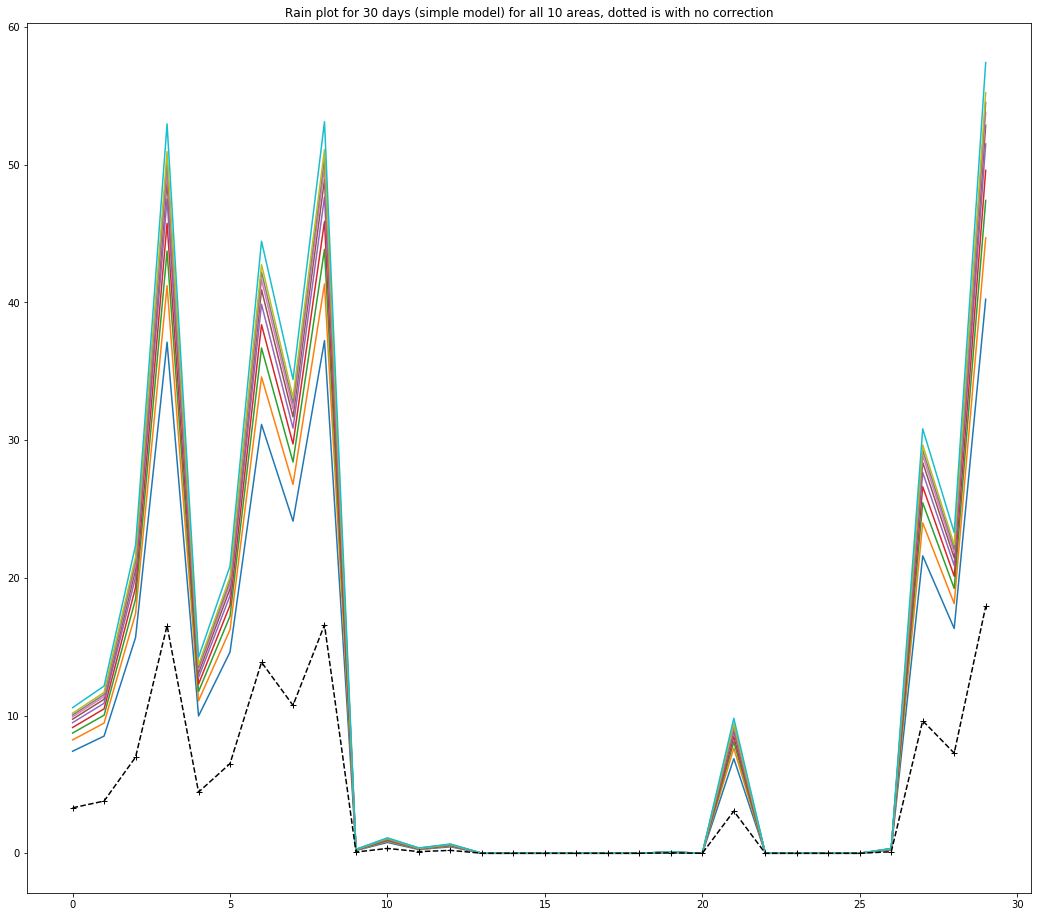

In [36]:
def generate_rain_data(df, params):
    rains = []
    for d in range(len(df)):
        # Loop through 10 distributed areas 
        elevation = []
        sum_height = params[ELEVS[0]]
        
        for i in range(10):
            # Calculate height of a given area by averaging lowest and highest height 
            height_low = params[ELEVS[i]]
            height_hig = params[ELEVS[i+1]]
            elevation.append((height_hig + height_low) / 2.0)
            
            sum_height += params[ELEVS[i+1]]
        
        # Find average height of catchment
        avg_height = sum_height / 11.0
        
        # Calculate elevation corrected rain
        rain = []
        for i in range(10):
            rain.append(params["RCORR"] * params["SCORR"] * df["mm"][d] * (1.0 + params["PGRAD"] * (elevation[i] - avg_height) / 100.0))
        rains.append(rain)
    return rains    

# Rain plot for a year (simple model) for all 10 areas
df = load_forcing_and_discharge(file_nr)
rains = generate_rain_data(df, params)

plt.figure(figsize=(18,16))
plt.plot(rains[0:30])
plt.plot(df["mm"][0:30], 'k--+')
plt.title("Rain plot for 30 days (simple model) for all 10 areas, dotted is with no correction")

In [37]:
def add_param_data_to_df(df, params):
    # Add evapotranspiration
    df["evapo_transp"] = generate_evapo_data(df, params)

    # Add temperature
    temps = generate_temp_data(df, params)
    for j in range(len(df)):
        for i in range(10):
            df["grC"+str(i+1)] = temps[j][i]

    # Add rain
    rains = generate_rain_data(df, params)
    for j in range(len(df)):
        for i in range(10):
            df["mm"+str(i+1)] = rains[j][i]
        
    return df

In [39]:
# Add evapo, temp (10 areas) and rain (10 areas)  
df = load_forcing_and_discharge(file_nr)
params = read_interesting_params(file_nr, interesting_keys)
df = add_param_data_to_df(df, params)

# Add observed, simulated and residual runoff
residual_df = read_output_simulated_residual_data(file_nr)
df["EPOT"] = residual_df["EPOT"]
df["Q_obs"] = residual_df["Q_obs"]
df["Q_sim"] = residual_df["Q_sim"]
df["Residual"] = residual_df["Residual"]

df.head()

<ipython-input-11-ecc3a6e4ca2c>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime.strptime(date + time, "%d.%m.%Y%H:%M:%S")


,timestamp,mm,grC,grC.1,m3/s,evapo_transp,grC1,grC2,grC3,grC4,...,mm5,mm6,mm7,mm8,mm9,mm10,EPOT,Q_obs,Q_sim,Residual
0,2000-01-01,3.30,-3.75,-3.75,0.27,0.1,-3.324545,-2.442045,-1.904545,-1.472045,...,11.927014,12.242793,12.45916,12.62582,12.789557,13.295388,0.1,0.27,0.006,-0.264
1,2000-01-02,3.79,-2.02,-2.02,0.27,0.1,-3.324545,-2.442045,-1.904545,-1.472045,...,11.927014,12.242793,12.45916,12.62582,12.789557,13.295388,0.1,0.27,0.025,-0.245
2,2000-01-03,6.98,-3.84,-3.84,0.27,0.1,-3.324545,-2.442045,-1.904545,-1.472045,...,11.927014,12.242793,12.45916,12.62582,12.789557,13.295388,0.1,0.27,0.047,-0.223
3,2000-01-04,16.53,-3.80,-3.80,0.29,0.1,-3.324545,-2.442045,-1.904545,-1.472045,...,11.927014,12.242793,12.45916,12.62582,12.789557,13.295388,0.1,0.29,0.080,-0.210
4,2000-01-05,4.44,-4.78,-4.78,0.31,0.1,-3.324545,-2.442045,-1.904545,-1.472045,...,11.927014,12.242793,12.45916,12.62582,12.789557,13.295388,0.1,0.31,0.100,-0.210


## Loop through and generate training data .csv file for all catchments

In [ ]:
file_nrs = [1, 6, 9, 14, 18, 25, 30, 38, 44, 65, 66, 88, 92, 94, 97, 99]
for file_nr in file_nrs:
    # Add evapo, temp (10 areas) and rain (10 areas)  
    df = load_forcing_and_discharge(file_nr)
    params = read_interesting_params(file_nr, interesting_keys)
    df = add_param_data_to_df(df, params)

    # Add observed, simulated and residual runoff
    residual_df = read_output_simulated_residual_data(file_nr)
    df["EPOT"] = residual_df["EPOT"]
    df["Q_obs"] = residual_df["Q_obs"]
    df["Q_sim"] = residual_df["Q_sim"]
    df["Residual"] = residual_df["Residual"]
    
    df.to_csv(f"../Training_data/rainfall_runoff_training_data_catchment_{file_nr}.csv") 
    print(f"File nr.:{file_nr} generated")


<ipython-input-11-ecc3a6e4ca2c>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime.strptime(date + time, "%d.%m.%Y%H:%M:%S")


File nr.:1 generated
File nr.:6 generated
File nr.:9 generated
File nr.:14 generated
File nr.:18 generated
File nr.:25 generated
File nr.:30 generated
File nr.:38 generated
File nr.:44 generated
File nr.:65 generated
File nr.:66 generated
File nr.:88 generated
File nr.:92 generated
File nr.:94 generated
File nr.:97 generated
